# Setup

In [1]:
# Import several packages that will be used throughout

# numeric packages
import numpy as np
import scipy
import scipy.io
import pandas as pd
import h5py

# filesystem and OS
import sys, os, time
import glob
import gzip
import cPickle as pickle

# plotting
from matplotlib import pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

# these magics ensure that external modules that are modified are also automatically reloaded
%load_ext autoreload
%autoreload 2

In [2]:
import keras
import tensorflow as tf

Using TensorFlow backend.


In [3]:
sys.path.append("../keras-utils/")
import keras_utils as ku

In [4]:
workdir = "/home/adalbert/nbserver/tf-workspace/urban-atlas-experiments/"

if not os.path.exists(workdir):
	os.makedirs(workdir)
    
os.chdir(workdir)

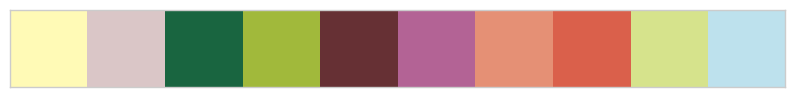

In [5]:
# load classes actually used in analysis

with gzip.open("classes.pickle.gz", "r") as f:
    dict_classes = pickle.load(f)

class2label = dict_classes["class2label"]
label2class = dict_classes["label2class"]
classes = np.sort(class2label.keys()).tolist()

N_CLASSES = len(classes)

# original colormap from Urban Atlas
class_colors_rgb = [
    ('Continuous Urban Fabric (S.L. > 80%)', (102, 48, 52)),
    ('Discontinuous Dense Urban Fabric (S.L. : 50% -  80%)', (167, 40, 49)),
    ('Discontinuous Medium Density Urban Fabric (S.L. : 30% - 50%)', (218, 96, 75)),
    ('Discontinuous Low Density Urban Fabric (S.L. : 10% - 30%)', (229, 144, 117)),
    ('Discontinuous Very Low Density Urban Fabric (S.L. < 10%)', (249, 171, 174)),
    ('Isolated Structures', (184, 117, 98)),
    ('Industrial, commercial, public, military and private units', (179, 99, 149)),
    ('Fast transit roads and associated land', (221, 110, 47)),
    ('Other roads and associated land', (236, 174, 128)),
    ('Railways and associated land', (119, 119, 118)),
    ('Port areas', (215, 187, 208)), 
    ('Airports', (218, 198, 199)),
    ('Mineral extraction and dump sites', (135, 100, 83)),
    ('Construction sites', (193, 161, 113)),
    ('Land without current use', (134, 88, 79)),
    ('Green urban areas', (161, 185, 59)),
    ('Sports and leisure facilities', (214, 227, 140)), 
    ('Agricultural + Semi-natural areas + Wetlands', (255, 250, 182)),
    ('Forests', (25, 101, 64)),
    ('Water bodies', (189, 225, 237)),
    ('Not Classified', (203, 204, 203))
]
class_colors_all = {c:(np.array(v)/float(255)).tolist() + [1.0] for c,v in class_colors_rgb}

consolidate_classes = {
    "Continuous Urban Fabric (S.L. > 80%)":"High Density Urban Fabric",
     "Discontinuous Dense Urban Fabric (S.L. : 50% -  80%)":"High Density Urban Fabric",
     "Discontinuous Medium Density Urban Fabric (S.L. : 30% - 50%)":"Medium Density Urban Fabric",
     "Discontinuous Low Density Urban Fabric (S.L. : 10% - 30%)":"Low Density Urban Fabric",
     "Discontinuous Very Low Density Urban Fabric (S.L. < 10%)":"Low Density Urban Fabric"
}
classes_consolidate = {v:[x for x in consolidate_classes.keys() if consolidate_classes[x] == v] \
                       for k,v in consolidate_classes.iteritems()}

label_colors = {i:class_colors_all[classes_consolidate[label2class[i]][0] \
                                   if label2class[i] in classes_consolidate else label2class[i]] \
                for i in range(N_CLASSES)}
class_colors = {c:v for c,v in zip(classes, label_colors.values())}

cmap = matplotlib.colors.ListedColormap([class_colors[c] for c in classes])

sns.palplot(sns.color_palette([v for c, v in label_colors.iteritems()]))

In [6]:
cities = ["athina", "berlin", "budapest", "roma", "barcelona", "madrid"]

palette_cities = dict(zip(cities, sns.color_palette("hls", len(cities))))

cmap_city = matplotlib.colors.ListedColormap(palette_cities.values())

# Load pretrained model and extract features

#### Load pretrained model

In [7]:
model_file = "./resnet50-urbanatlas-berlin+bucuresti+dublin+tallinn+barcelona-0.70-checkpoint.h5"

# with tf.device('/cpu:0'):
# load model and weights

# load & compile models
from keras.optimizers import Adadelta

model = keras.models.load_model(model_file)
model.compile(loss='categorical_crossentropy', \
              metrics=['accuracy'],\
              optimizer=Adadelta(lr=0.01))

#### Load & preprocess data, use model to extract features

In [8]:
# extract activations for a batch of images

from keras import backend as K

def get_activations(model, layer_id, X_batch):
    layer_dict = {l.name:l for l in model.layers}
    if type(layer_id) is str:
        feat_layer = layer_dict[layer_id]
    else:
        feat_layer = model.layers[layer_id]
    fn_activations = K.function([model.layers[0].input, K.learning_phase()], \
                                 [feat_layer.output,])
    activations = fn_activations([X_batch,0])[0]
    return activations


# extract features 

def extract_features(model, sources, batch_size=100, layer=None):
    n_chunks = int(np.ceil(len(sources) / batch_size))
    chunks = np.array_split(sources, n_chunks)
    features = []
    for idx, chunk in enumerate(chunks):
        clear_output(wait=True)
        print "Chunk %d / %d" % (idx, n_chunks)
        batch = []
        for s in chunk:
            filename, label = s
            img = ku.load_and_preprocess(filename) * 1.0/255.0
            batch.append(img)
        batch = np.array(batch)
        if layer is None:
            pred = model.predict(batch)
        else:
            pred = get_activations(model, layer, batch)
        features.append(pred)
    features = np.vstack(features)
    return features

In [23]:
files_df = pd.concat([pd.read_csv("./%s-test.csv"%c) for c in cities])
files_df.shape

(31506, 4)

In [24]:
files_df = files_df.groupby("city").apply(lambda df: ku.balanced_df(df, nrows=1000))

In [25]:
files_df.shape

(6000, 4)

In [26]:
sources = zip(files_df['filename'].values, files_df['class'].values)
features = extract_features(model, sources, layer="flatten_1")
features = np.vstack(features)

Chunk 59 / 60


In [27]:
features.shape

(6000, 2048)

In [28]:
np.savez_compressed("features_batch2.npz", features)

# with np.load("features_batch.npz") as data:
#     print data.keys()
#     features = data['arr_0']

# t-SNE visualization using extracted features

#### Compute tSNE projection

In [29]:
# https://github.com/DmitryUlyanov/Multicore-TSNE

from MulticoreTSNE import MulticoreTSNE as TSNE

tsne = TSNE(n_jobs=32, perplexity=20)
feats_tsne = tsne.fit_transform(features.astype(np.float64))

#### Visualize tSNE scatterplots

In [331]:
import seaborn as sns
import matplotlib.patheffects as PathEffects

def labeled_scatterplot(x, labels, palette=None, ax=None, add_text=True, alpha=None, figsize=None):
    
    classes = np.unique(labels)
    class_dict = {c:i for i,c in enumerate(classes)}
    n_clust = len(classes)    
    colors = [palette[l] for l in labels]

    # We create a scatter plot.
    if ax is None:
        f = plt.figure(figsize=figsize)
        ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=colors, alpha=alpha)
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')

    if add_text:
        # We add the labels for each class.
        txts = []
        for k,c in enumerate(classes):
            # Position of each label.
            xtext, ytext = np.median(x[labels == c, :], axis=0)
            txt = ax.text(xtext, ytext, str(c), fontsize=24)
            txt.set_path_effects([
                PathEffects.Stroke(linewidth=5, foreground=palette[c]),
                PathEffects.Normal()])
            txts.append(txt)

    return ax

In [31]:
import re
import abbreviate
abbr = abbreviate.Abbreviate()

def split_str(s):
    s = re.sub('[^A-Za-z0-9% ]+', '', s)
    words = s.split(" ")
    words = [abbr.abbreviate(w, target_len=10).capitalize() for w in words]
    if len(words)==1:
        return s #+ "\n"
    if len(words)>4:
        words = words[:3] + [words[-1]]
    else:
        words = words[:4]
    return " ".join(words[:(len(words)/2)]) + "\n" + " ".join(words[(len(words)/2):])


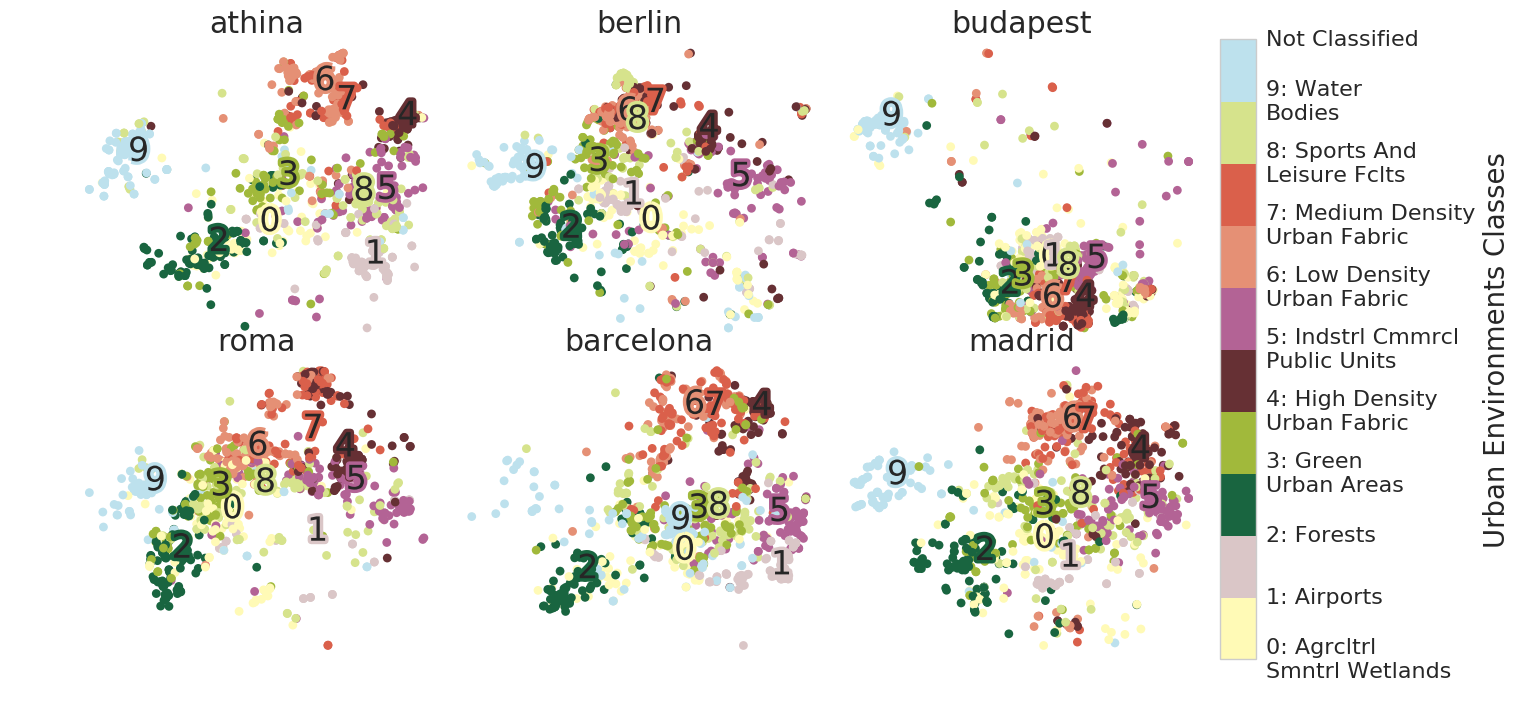

In [369]:
# embeddings plot over cities

sns.set_context("notebook", font_scale=1.8, rc={"lines.linewidth": 1})

plt.figure(figsize=(30,8))
width_ratios = [10 for _ in range(len(cities)/2)] + [1] + [10 for _ in range(len(cities)/2)] + [1]
gs = matplotlib.gridspec.GridSpec(2, len(cities)/2+1, width_ratios=width_ratios, wspace=0.025, hspace=0.05)
ax_cbar = plt.subplot(gs[:,-1])

myticks = range(N_CLASSES) + [10]
myticklabels = [split_str(c) for c in classes] + ["Not Classified"]
myticklabels = ["%d: %s"%(i,split_str(c)) for i,c in enumerate(classes)] + ["Not Classified"]

cb3 = matplotlib.colorbar.ColorbarBase(ax_cbar, cmap=cmap,
                                boundaries=myticks,
                                ticks=myticks,
                                orientation="vertical",
                                ticklocation="right",
                                spacing='uniform')
cb3.set_label('Urban Environments Classes')
cb3.ax.set_yticks(myticks)
cb3.ax.set_yticklabels(myticklabels, fontsize=16)

for n,c in enumerate(cities):
    i = n / 3; j = n % 3
    ax = plt.subplot(gs[i,j])
    idx = files_df['city']==c
    labels = files_df[idx]['class'].apply(lambda x: class2label[x])
    ax = labeled_scatterplot(feats_tsne[idx,:], labels, ax=ax, palette=label_colors)
    ax.set_title(c)

#### Visualize "distance" between cities as a network plot

In [189]:
def compute_network(x, labels):
    df = pd.DataFrame(x).rename(columns={0:"x", 1:"y"})
    df['label'] = labels
    med_df = df.groupby("label").apply(lambda x: x.median())
    med_df = med_df.ix[cities]
    
    D = np.zeros((len(cities), len(cities)))
    for i,c1 in enumerate(cities):
        points_c1 = df[df['label']==c1].drop("label", 1).values
        m1 = med_df[med_df.index==c1].iloc[0].values
        d1 = ((points_c1 - m1)**2).sum(1)
        s1 = d1.std()
        for j,c2 in enumerate(cities):
            points_c2 = df[df['label']==c2].drop("label", 1).values
            m2 = med_df[med_df.index==c2].iloc[0].values
            s2 = ((points_c2 - m2)**2).sum(1).std()
            if i == j:
                D[i,j] = d1[d1 < d1.mean() + d1.std()].sum() / (float(len(points_c1))**2)
            else:
                D[i,j] = d1[d1 > d1.mean() + d1.std()].sum() / (float(len(points_c1))**2)
    D = 0.5*(D + D.T)
    
    return med_df, D

In [241]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

def plot_network(med_df, D, ax=None):
    # create a graph object, add n nodes to it, and the edges
    G = nx.Graph()
    for i, (c, loc) in enumerate(dict(zip(med_df.index, zip(med_df.x, med_df.y))).iteritems()):
        G.add_node(c, pos=loc, size=D[i,i])

    for i,c1 in enumerate(med_df.index):
        for j,c2 in enumerate(med_df.index):
            G.add_edge(c1, c2, weight=D[i,j])

    # use one of the edge properties to control line thickness
    edgewidth = [ d['weight'] for (u,v,d) in G.edges(data=True)]

    # layout
    pos=nx.get_node_attributes(G,'pos')

    # rendering
    if ax is None:
        fig, ax = plt.subplots()
    ax.axis('off')
    
    # rendering
    nx.draw_networkx_nodes(G, pos, ax=ax,
                           node_color=[cmap_city(i) for i in range(len(cities))],
                           node_size=[G.node[n]['size']*200 for n in G.nodes()])
    nx.draw_networkx_edges(G, pos, ax=ax, 
                           edge_color=edgewidth, width=edgewidth)
#     nx.draw_networkx_labels(G,
#                             {c:(x[0],x[1]+2.5) for c, x in pos.iteritems()},
#                             {x:x for x in G.nodes()},
#                             ax=ax,
#                             font_size=16)
    return ax

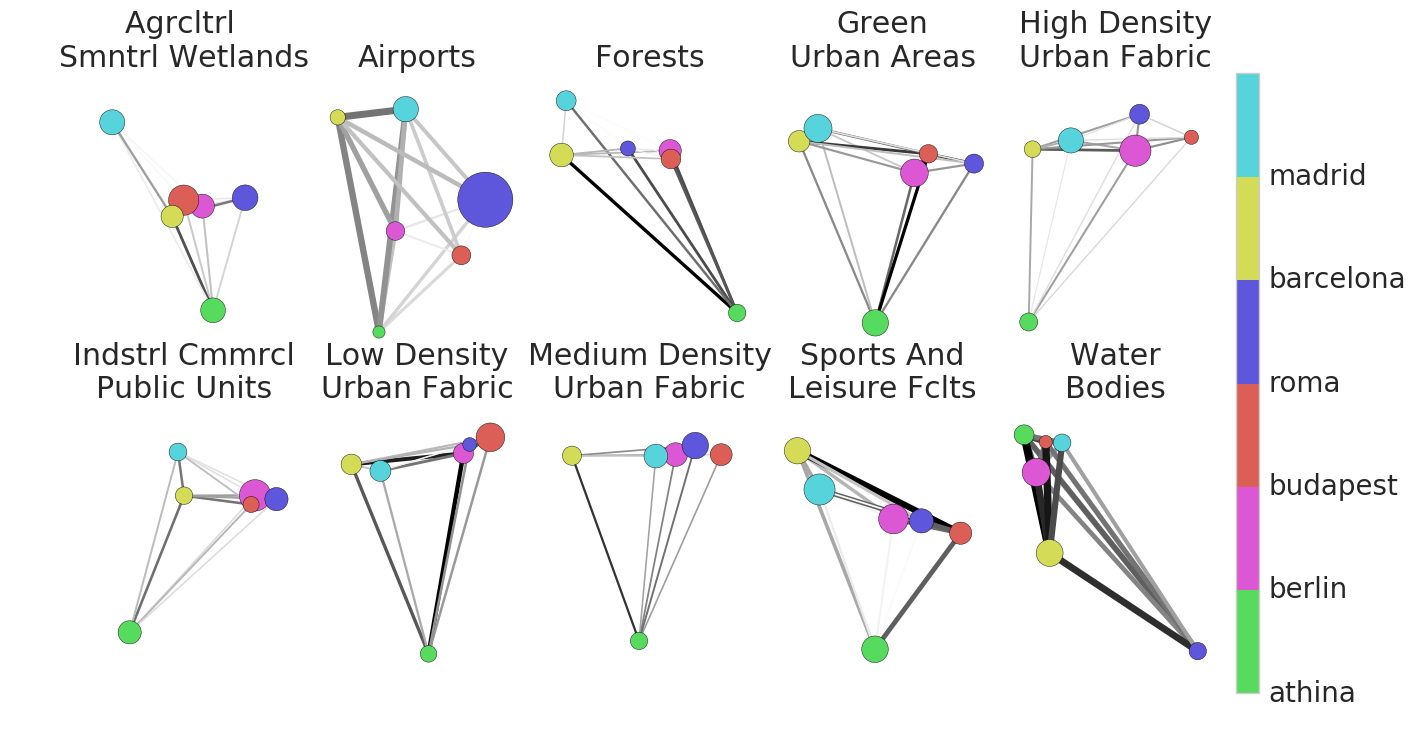

In [366]:
# embeddings plot over classes

sns.set_context("notebook", font_scale=1.8, rc={"lines.linewidth": 1})

plt.figure(figsize=(30,8))
width_ratios = [10 for _ in range(len(classes)/2)] + [1] + [10 for _ in range(len(classes)/2)] + [1]
gs = matplotlib.gridspec.GridSpec(2, len(classes)/2+1, width_ratios=width_ratios, wspace=0.025, hspace=0.15)
ax_cbar = plt.subplot(gs[:,-1])

myticks = range(len(cities))
myticklabels = cities

cb3 = matplotlib.colorbar.ColorbarBase(ax_cbar, cmap=cmap_city,
                                boundaries=myticks + [len(cities)],
                                ticks=myticks,
                                orientation="vertical",
                                ticklocation="right",
                                spacing='uniform')
cb3.ax.set_yticks(myticks)
cb3.ax.set_yticklabels(myticklabels, fontsize=20)
city_label = {c:i for i,c in enumerate(cities)}

for n,c in enumerate(classes):
    i = n / 5; j = n % 5
    ax = plt.subplot(gs[i,j])
    idx = files_df['class']==c
    labels = files_df[idx]['city'].values 
    feats = feats_tsne[idx,:]
    
    med_df, D = compute_network(feats, labels)
    ax = plot_network(med_df, D, ax=ax)
    ax.set_title(split_str(c))

#### Plot examples 

In [315]:
from matplotlib.patches import Circle
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)

def plot_samples(locations, images, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,4))

    # Define a 1st position to annotate (display it with a marker)
    for xy, arr_img in zip(locations, images):
        imagebox = OffsetImage(arr_img, zoom=0.3)
        imagebox.image.axes = ax

        ab = AnnotationBbox(imagebox, xy,
                            xybox=(-20, 40),
                            xycoords='data',
                            pad=0.1,
                            boxcoords="offset points",
                            arrowprops=dict(arrowstyle="->"))
        ax.add_artist(ab)
    return ax

In [244]:
from scipy.spatial import cKDTree
from sklearn.neighbors import KDTree, BallTree

tree = KDTree(feats_tsne)

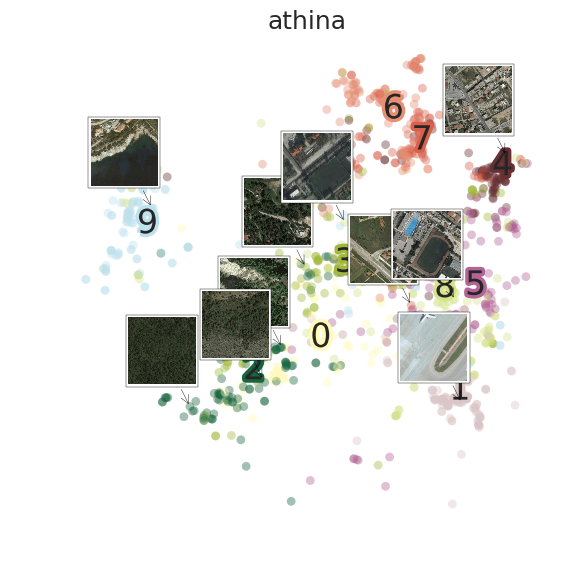

In [361]:
from skimage.io import imread

city = "athina"
idx = files_df['city']==city
labels = files_df[idx]['class'].apply(lambda x: class2label[x])
feats = feats_tsne[idx,:]
filenames = files_df[idx]['filename'].values

n_samples = 10
idx_sel = np.random.choice(range(len(labels)), n_samples)
locs = feats[idx_sel,:]
images = [imread(f) for f in filenames[idx_sel]]

ax = labeled_scatterplot(feats, labels, palette=label_colors, alpha=0.4, figsize=(6,6))
plot_samples(locs, images, ax=ax)
plt.title(city)

# "Similar" urban environments within and across two example cities

We would like to study how "similar" different classes of urban environments are across two example cities. For this:
* get samples for rasters for the two cities (at most 2 $\times$ 10,000)
* construct KD tree with the raster samples
* pick 100 samples per class for each city
* for each sample, find the top 10 neighbors from among all samples, record the city, and class of each neighbor
* compute statistics per each class (% neighbors of same city/class, different city/class)

In [ ]:
import re
import abbreviate
abbr = abbreviate.Abbreviate()

def split_str(s, target_len=12):
    s = re.sub('[^A-Za-z0-9% ]+', '', s)
    words = s.split(" ")
    words = [abbr.abbreviate(w, target_len=target_len).capitalize() for w in words]
    if len(words)==1:
        return s #+ "\n"
    if len(words)>4:
        words = words[:3] + [words[-1]]
    else:
        words = words[:4]
    return " ".join(words[:(len(words)/2)]) + "\n" + " ".join(words[(len(words)/2):])


In [ ]:
mycities = ["barcelona", "berlin"]

#### Get grid source files

In [ ]:
data_path = "/home/adalbert/data/urban-atlas/extracted-data/"

def get_grid_sources(cities):
    files = np.array([f for c in cities for f in glob.glob(data_path + "%s/img/*/*.jpg"%c)])
    files_df =  pd.DataFrame(files).rename(columns={0:"filename"})
    files_df['class'] = files_df['filename'].apply(lambda x: x.split("/")[-2])
    files_df['city'] = files_df['filename'].apply(lambda x: x.split("/")[-4])
    files_df['phase'] = files_df['filename'].apply(lambda x: "validation" if "grid" in x else "training")
    files_df['class'] = files_df['class'].apply(
        lambda x: consolidate_classes[x] if x in consolidate_classes else x)
    files_df = files_df[files_df['class'].isin(classes)]
    files_grid_df = files_df[files_df['phase']=='validation']
    return files_grid_df

In [ ]:
files_df = get_grid_sources(mycities)

In [ ]:
files_df.shape

#### Load pre-trained models

In [ ]:
model_files = {"resnet50":"./resnet50-urbanatlas-berlin+bucuresti+dublin+tallinn+barcelona-0.70-checkpoint.h5",
               "vgg16":"./vgg16-urbanatlas-berlin+bucuresti+dublin+tallinn+barcelona-0.68-checkpoint.h5"}

last_layer = {"resnet50":"flatten_1", 
              "vgg16":"dense7"}

In [ ]:
from keras.optimizers import Adadelta

features_grid = {}
for architecture, model_file in model_files.iteritems():
    # load & compile models
    model = keras.models.load_model(model_file)
    model.compile(loss='categorical_crossentropy', \
              metrics=['accuracy'],\
              optimizer=Adadelta(lr=0.01))
    
    sources = zip(files_df['filename'].values, files_df['class'].values)
    features_grid[architecture] = np.vstack(extract_features(model, sources, layer=last_layer[architecture]))   

In [ ]:
np.savez_compressed("features_grid.npz", features_grid)

#### Construct KD-trees, get neighbors for samples

In [ ]:
from scipy.spatial import cKDTree
from sklearn.neighbors import KDTree, BallTree

In [ ]:
N_SAMPLES = 100

In [ ]:
# build KD tree 

feats = features_grid['resnet50']
tree = KDTree(feats)

In [ ]:
# get 100 samples per class per city
# make sure 

samples = files_df.groupby(["class", "city"]).apply(lambda x: x.sample(N_SAMPLES, replace=True))

idx = samples.index.get_level_values(-1)
samples = files_df.ix[idx]
idx0 = np.array([np.where(files_df.index==i)[0][0] for i in idx])
feats_sel = feats[idx0,:]

samples.head()

In [ ]:
_, neighbors = tree.query(feats_sel, k=10)

In [ ]:
stats = []
for i in range(neighbors.shape[0]):
    r = files_df.iloc[neighbors[i,:]]
    confm = (sum((r['city'] == samples.iloc[i]['city']) & (r['class'] == samples.iloc[i]['class'])),
             sum((r['city'] != samples.iloc[i]['city']) & (r['class'] == samples.iloc[i]['class'])),
             sum((r['city'] == samples.iloc[i]['city']) & (r['class'] != samples.iloc[i]['class'])),
             sum((r['city'] != samples.iloc[i]['city']) & (r['class'] != samples.iloc[i]['class'])))
    stats.append(confm)

stats_df = pd.DataFrame(stats, columns=["=city,=class", "!city,=class", "=city,!class", "!city,!class"])

In [ ]:
stats_df.head()

In [ ]:
stats_df = pd.concat([samples.reset_index().drop("index",1), stats_df], 1)

In [ ]:
stats_df.head()

In [ ]:
tot_stats_df = stats_df.groupby(["class", "city"]).apply(sum).drop(["filename", "class", "city", "phase"],1)

tot_stats_df = (tot_stats_df.T / tot_stats_df.sum(1)).T
tot_stats_df = tot_stats_df.reset_index()
tot_stats_df['class'] = tot_stats_df['class'].apply(split_str)

In [ ]:
mlt_df = pd.melt(tot_stats_df, id_vars=["class", "city"])

In [ ]:
mlt_df.head()

In [ ]:
tot_stats_df

In [ ]:
import pandas as pd
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt

def plot_clustered_stacked(dfall, labels=None, title="multiple stacked bar plot",  H="/", **kwargs):
    """Given a list of dataframes, with identical columns and index, create a clustered stacked bar plot. 
labels is a list of the names of the dataframe, used for the legend
title is a string for the title of the plot
H is the hatch used for identification of the different dataframe"""

    n_df = len(dfall)
    n_col = len(dfall[0].columns) 
    n_ind = len(dfall[0].index)
    axe = plt.subplot(111)

    for df in dfall : # for each data frame
        axe = df.plot(kind="bar",
                      linewidth=0,
                      stacked=True,
                      ax=axe,
                      legend=False,
                      grid=False,
                      **kwargs)  # make bar plots

    h,l = axe.get_legend_handles_labels() # get the handles we want to modify
    for i in range(0, n_df * n_col, n_col): # len(h) = n_col * n_df
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: # for each index
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col)) #edited part     
                rect.set_width(1 / float(n_df + 1))

    axe.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axe.set_xticklabels(df.index, rotation = 90)
    axe.set_title(title)

    # Add invisible data to add another legend
    n=[]        
    for i in range(n_df):
        n.append(axe.bar(0, 0, color="gray", hatch=H * i))

    l1 = axe.legend(h[:n_col], l[:n_col], loc=[1.01, 0.5])
    if labels is not None:
        l2 = plt.legend(n, labels, loc=[1.01, 0.1]) 
    axe.add_artist(l1)
    return axe

In [ ]:
df1 = tot_stats_df[tot_stats_df.city=='berlin'].drop("city",1).set_index("class")
df2 = tot_stats_df[tot_stats_df.city=='barcelona'].drop("city",1).set_index("class")

In [ ]:
# Then, just call :
plot_clustered_stacked([df1, df2],["berlin", "barcelona"], "Similarity of Urban Environments")


#### Plot examples of similar environments

In [ ]:
from skimage.io import imread
from skimage.transform import resize

In [ ]:
examples = samples[samples.city=='barcelona'].groupby("class").apply(lambda x: x.sample())
examples = examples[examples['class'].isin(["Airports", "High Density Urban Fabric", "Green urban areas"])]

In [ ]:
ex_idx = examples.index.get_level_values(-1)
ex_idx0 = np.array([np.where(samples.index==i)[0][0] for i in ex_idx])

In [ ]:
examples_neighbors = neighbors[ex_idx0,1:4]

In [ ]:
examples_neighbors

In [ ]:
canvass = []
for i in range(examples_neighbors.shape[0]):
    row = []
    img, label = imread(examples.iloc[i]['filename']), examples.index[i]
    row.append(np.pad(resize(img, (100,100)), (2,2), "constant", constant_values=(0))[:,:,2:5])
    cur_df = files_df.iloc[examples_neighbors[i,:],:]
    for _, r in cur_df.iterrows():
        img, label = imread(r['filename']), r['class']
        row.append(np.pad(resize(img, (100,100)), (2,2), "constant")[:,:,2:5])
    canvass.append(np.hstack(row))
canvass = np.vstack(canvass)

In [ ]:
plt.figure(figsize=(14,6))
plt.imshow(canvass)
plt.yticks([52 + i * 104 for i in range(3)], [split_str(x) for x in examples.index.get_level_values(0).values])
plt.xticks([52 + i * 104 for i in range(4)], ["query image", "neighbor 1", "neighbor 2", "neighbor 3"])
plt.title("Similar Urban Environments in Barcelona: Examples")